In [1]:
import pandas as pd

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)
y[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [3]:
y.shape

(630801, 397)

In [4]:
import numpy as np

In [5]:
np.sqrt(12*50)

24.49489742783178

In [6]:
cens = train_df.cens_slice
cens.shape

(630801,)

In [7]:
from collections import Counter
Counter(cens.apply(lambda x: x.shape))

Counter({(12, 50): 629359,
         (12, 49): 279,
         (12, 46): 159,
         (12, 48): 236,
         (12, 41): 61,
         (12, 44): 134,
         (12, 42): 83,
         (12, 45): 130,
         (12, 47): 199,
         (12, 43): 110,
         (12, 40): 29,
         (12, 39): 18,
         (12, 38): 4})

In [8]:
def reshape_square(arr, k=25):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros(k*k)
    a = arr.reshape(-1)
    x[:a.shape[0]] = a
    return x.reshape(k, k, 1)
    
X = np.stack(cens.apply(reshape_square))

In [9]:
X.shape

(630801, 25, 25, 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
X_train.shape

(441560, 25, 25, 1)

In [12]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
train_dataset

<TensorSliceDataset shapes: ((25, 25, 1), (397,)), types: (tf.float64, tf.int32)>

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

tf.config.list_physical_devices('GPU')
def get_compiled_model(input_shape=(25, 25, 1), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [ ]:
model = get_compiled_model()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

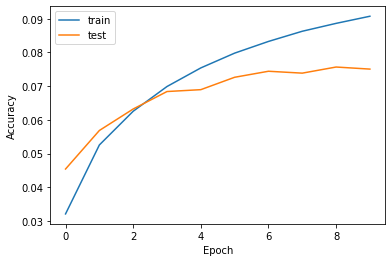

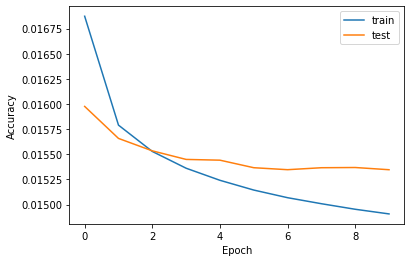

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# model.evaluate(X_test, y_test, verbose=2)